# Imports

In [1]:
import sys
import pandas as pd
import warnings

sys.path.append('../../src')
warnings.filterwarnings('ignore')

In [2]:
from data_loading import YearLoader
from stats_helpers import *

# Weather conditions

Get the number of accident and the gravity of each accident given the atmospheric conditions

## Helpers

In [3]:
def atm_code_to_str(atm_code):
    """
    Function that convert an atmospheric code to its string value
    
    Parameters
    ----------
    atm_code : int
        The code of the atmospheric conditions
    
    Returns
    -------
    String
        The string value
    """
    
    dict_atm_code = {
        1 : "Normal",
        2 : "Light rainfall",
        3 : "Heavy rainfall",
        4 : "Snow - hail",
        5 : "Fog - smoke",
        6 : "Strong wind - storm",
        7 : "Dazzling weather",
        8 : "Covered weather",
        9 : "Other",
    }
    
    return dict_atm_code[atm_code]

In [4]:
def gravity_code_to_string(grav_code):
    """
    Function that convert a code of gravity to its string value
    
    Parameters
    ----------
    grav_code : int
        The code of the accident's gravity
    
    Returns
    -------
    String
        The string value
    """
    
    dict_gravity_code = {
        1 : "Unharmed",
        2 : "Killed",
        3 : "Injured and hospitalized",
        4 : "Slightly injured",
    }
    
    return dict_gravity_code[grav_code]

In [5]:
loader = YearLoader(2018)

In [6]:
charac = loader.get_dataframe('characteristics')
charac.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep
0,201800000001,18,1,24,1505,1,1,4,1.0,1.0,5,route des Ansereuilles,M,5055737.0,294992.0,590
1,201800000002,18,2,12,1015,1,2,7,7.0,7.0,11,Place du général de Gaul,M,5052936.0,293151.0,590
2,201800000003,18,3,4,1135,1,2,3,1.0,7.0,477,Rue nationale,M,5051243.0,291714.0,590
3,201800000004,18,5,5,1735,1,2,1,7.0,3.0,52,30 rue Jules Guesde,M,5051974.0,289123.0,590
4,201800000005,18,6,26,1605,1,2,1,1.0,3.0,477,72 rue Victor Hugo,M,5051607.0,290605.0,590


In [7]:
charac["Num_Acc"].is_unique

True

## Number of accidents given the weather

In [8]:
def get_accident_per_weather(year):
    """
    Function that returns a Dataframe containing for each type 
    of weather the count and the percentage of accidents
    
    Parameters
    ----------
    year : int
        The year
    
    Returns
    -------
    DataFrame
        The dataframe containing the number of accidents
    """
    
    # Load the dataset
    loader = YearLoader(year)
    charac = loader.get_dataframe('characteristics')
    charac = charac.dropna(subset=['atm'])
    charac['atm'] = charac['atm'].astype(int)
    
    # Extract the count of accidents
    df_accidents = charac["atm"].value_counts().sort_index().rename_axis('weather').reset_index(name='accidents')
    df_accidents["weather"] = df_accidents["weather"].apply(lambda x : atm_code_to_str(x))
    # Adding percentage
    count = df_accidents["accidents"].sum()
    df_accidents["perc"] = df_accidents["accidents"] / count * 100
    
    return df_accidents.set_index('weather')
    
def get_accident_per_weather_years(years):
    """
    Function that returns a Dataframe containing for each type 
    of weather the count and the percentage of accidents given
    multiple years
    
    Parameters
    ----------
    years : list(int)
        The list of the years
    
    Returns
    -------
    DataFrame
        The dataframe containing the number of accidents
    """
    
    df_full = get_accident_per_weather(years[0])
    
    for year in years[1:]:
        df_year = get_accident_per_weather(year)
        df_full += df_year
    
    # Fixing percentages
    count = df_full["accidents"].sum()
    df_full["perc"] = df_full["accidents"]/count * 100
        
    return df_full

### For the year 2008

In [9]:
df_full = get_accident_per_weather(2018)
df_full.head()

,accidents,perc
weather,,
Normal,45824,79.310464
Light rainfall,6350,10.990342
Heavy rainfall,1333,2.307107
Snow - hail,358,0.619613
Fog - smoke,427,0.739036


### For the years between 2008 and 2018

In [10]:
df_full = get_accident_per_weather_years(list(range(2008, 2019)))
df_full.head()

,accidents,perc
weather,,
Normal,568065,80.630693
Light rainfall,74927,10.635079
Heavy rainfall,15767,2.237955
Snow - hail,4134,0.586777
Fog - smoke,4531,0.643127


## Gravity given weather

In [11]:
def grav_weather_year(year):
    """
    Function that returns a Dataframe containing 
    for a year the count of accidents and the 
    percentage given a gravity 
    
    Parameters
    ----------
    year : int
        The year
    
    Returns
    -------
    DataFrame
        The dataframe containing the number of accidents
    """
    
    # Loading datasets
    loader = YearLoader(year)
    charac = loader.get_dataframe('characteristics')
    charac = charac.dropna(subset=['atm'])
    charac['atm'] = charac['atm'].astype(int)
    
    # Empty dataset for the results
    df_full = pd.DataFrame()
    
    for atm in range(1, 10):
        # Loop for each atm condition
        
        # Keeping only the number of the accidents given the atm code
        df_atm = charac[charac["atm"] == atm]
        list_accidents = df_atm["Num_Acc"]
        
        # Keeping the passengers of the previous accidents
        passengers = loader.get_dataframe("passengers")
        passengers = passengers[passengers["Num_Acc"].isin(list_accidents)]
        
        # Counting the gravity of the accidents
        df_res = passengers["grav"].value_counts().sort_index().rename_axis('grav').reset_index(name='counts')        
        
        # Adding percentage and atm code
        sum_acc = df_res["counts"].sum()
        df_res["perc"] = df_res["counts"] / sum_acc * 100 # Adding percentage
        df_res["atm"] = atm                                 # Add atm code
        
        # Append to full dataset
        df_full = df_full.append(df_res)
    
    # Codes to strings
    df_full["atm"] = df_full["atm"].apply(lambda x : atm_code_to_str(x))
    df_full["grav"] = df_full["grav"].apply(lambda x : gravity_code_to_string(x))
    
    # Set correct indexes
    df_full = df_full.set_index(["atm", "grav"])
    
    return df_full

In [12]:
def grav_weather_over_years(years):
    """
    Function that returns a Dataframe containing 
    for several years the count of accidents and 
    the percentage given a gravity 
    
    Parameters
    ----------
    years : list(int)
        The years
    
    Returns
    -------
    DataFrame
        The dataframe containing the number of accidents
    """
    
    df_res = grav_weather_year(years[0])
    
    # Adding results
    for year in years[1:]:
        df_res = df_res + grav_weather_year(year)
    
    # Fixing percentages   
    # Get count of acc for each atm
    dict_count = df_res.groupby(["atm"]).sum(columns=["counts"]).to_dict()["counts"]
    # Reset index to access all fields
    df_res = df_res.reset_index()
    for i in range(len(df_res)):
        # Compute percentages
        df_res.ix[i, "perc"] = df_res.iloc[i]["counts"] * 100 / dict_count[df_res.iloc[i]["atm"]]
    
    return df_res.set_index(["atm", "grav"])

### For the year 2018

In [13]:
df_res = grav_weather_year(2018)
df_res

counts       perc
atm                 grav                                       
Normal              Unharmed                   43337  41.867048
                    Killed                      2645   2.555284
                    Injured and hospitalized   17546  16.950855
                    Slightly injured           39983  38.626813
Light rainfall      Unharmed                    5734  41.001073
                    Killed                       281   2.009296
                    Injured and hospitalized    2188  15.645334
                    Slightly injured            5782  41.344297
Heavy rainfall      Unharmed                    1237  39.762134
                    Killed                       100   3.214401
                    Injured and hospitalized     561  18.032787
                    Slightly injured            1213  38.990678
Snow - hail         Unharmed                     379  42.346369
                    Killed                        25   2.793296
                    Injured and hospitalized     125  13.966480
                    Slightly injured             366  40.893855
Fog - smoke         Unharmed                     347  36.719577
                    Killed                        66   6.984127
                    Injured and hospitalized     240  25.396825
                    Slightly injured             292  30.899471
Strong wind - storm Unharmed                     103  40.234375
                    Killed                        12   4.687500
                    Injured and hospitalized      68  26.562500
                    Slightly injured              73  28.515625
Dazzling weather    Unharmed                    1047  44.364407
                    Killed                        84   3.559322
                    Injured and hospitalized     563  23.855932
                    Slightly injured             666  28.220339
Covered weather     Unharmed                    1839  40.994204
                    Killed                       141   3.143112
                    Injured and hospitalized     737  16.428890
                    Slightly injured            1769  39.433794
Other               Unharmed                     223  36.497545
                    Killed                        36   5.891980
                    Injured and hospitalized     141  23.076923
                    Slightly injured             211  34.533552

### For the years between 2008 and 2018

In [14]:
df_res = grav_weather_over_years(list(range(2008, 2019)))
df_res

counts       perc
atm                 grav                                       
Normal              Unharmed                  521212  41.197840
                    Killed                     32855   2.596938
                    Injured and hospitalized  257930  20.387403
                    Slightly injured          453147  35.817820
Light rainfall      Unharmed                   65647  40.003047
                    Killed                      3753   2.286950
                    Injured and hospitalized   30620  18.658786
                    Slightly injured           64085  39.051217
Heavy rainfall      Unharmed                   14039  39.364625
                    Killed                      1108   3.106774
                    Injured and hospitalized    7783  21.823127
                    Slightly injured           12734  35.705473
Snow - hail         Unharmed                    4241  41.738018
                    Killed                       332   3.267395
                    Injured and hospitalized    2257  22.212381
                    Slightly injured            3331  32.782206
Fog - smoke         Unharmed                    3966  36.817675
                    Killed                       701   6.507612
                    Injured and hospitalized    3283  30.477163
                    Slightly injured            2822  26.197549
Strong wind - storm Unharmed                    1274  35.556796
                    Killed                       213   5.944739
                    Injured and hospitalized    1034  28.858498
                    Slightly injured            1062  29.639967
Dazzling weather    Unharmed                    7730  42.906306
                    Killed                       823   4.568162
                    Injured and hospitalized    5211  28.924290
                    Slightly injured            4252  23.601243
Covered weather     Unharmed                   20100  39.474459
                    Killed                      1953   3.835503
                    Injured and hospitalized   11441  22.469019
                    Slightly injured           17425  34.221018
Other               Unharmed                    3783  35.547829
                    Killed                       510   4.792332
                    Injured and hospitalized    2821  26.508175
                    Slightly injured            3528  33.151663

# Weather Statistics

In [15]:
years = list(range(2008,2019))

In [16]:
data = stats_df_weather_gravity(years)

In [17]:
Chi_square_gravity_vs_seatbelt = ChiSquare(data['atm'],data['grav'])

contingency_table :-
 grav       1      2       3       4
atm                                
1     521212  32855  257930  453147
2      65647   3753   30620   64085
3      14039   1108    7783   12734
4       4241    332    2257    3331
5       3966    701    3283    2822
6       1274    213    1034    1062
7       7730    823    5211    4252
8      20100   1953   11441   17425
9       3783    510    2821    3528
Observed Values :-
 [[521212  32855 257930 453147]
 [ 65647   3753  30620  64085]
 [ 14039   1108   7783  12734]
 [  4241    332   2257   3331]
 [  3966    701   3283   2822]
 [  1274    213   1034   1062]
 [  7730    823   5211   4252]
 [ 20100   1953  11441  17425]
 [  3783    510   2821   3528]]
Expected Values :-
 [[5.17660434e+05 3.40660289e+04 2.59946184e+05 4.53471353e+05]
 [6.71470327e+04 4.41879001e+03 3.37182712e+04 5.88209061e+04]
 [1.45926801e+04 9.60310332e+02 7.32779882e+03 1.27832107e+04]
 [4.15758812e+03 2.73601202e+02 2.08775695e+03 3.64205372e+03]
 [4.407591

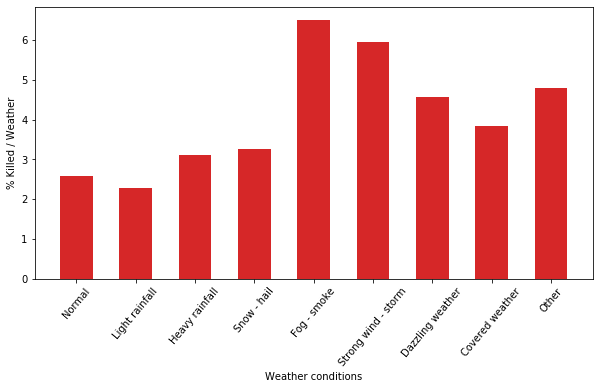

In [18]:
plot_weather_vs_gravity_contingency()

In [19]:
def grav_weather_year(year):
    """
    Function that returns a Dataframe containing 
    for a year the count of accidents and the 
    percentage given a gravity 
    
    Parameters
    ----------
    year : int
        The year
    
    Returns
    -------
    DataFrame
        The dataframe containing the number of accidents
    """
    
    # Loading datasets
    loader = YearLoader(year)
    charac = loader.get_dataframe('characteristics')
    charac = charac.dropna(subset=['atm'])
    charac['atm'] = charac['atm'].astype(int)
    
    # Empty dataset for the results
    df_full = pd.DataFrame()
    
    for atm in range(1, 10):
        # Loop for each atm condition
        
        # Keeping only the number of the accidents given the atm code
        df_atm = charac[charac["atm"] == atm]
        list_accidents = df_atm["Num_Acc"]
        
        # Keeping the passengers of the previous accidents
        passengers = loader.get_dataframe("passengers")
        passengers = passengers[passengers["Num_Acc"].isin(list_accidents)]
        
        # Counting the gravity of the accidents
        df_res = passengers["grav"].value_counts().sort_index().rename_axis('grav').reset_index(name='counts')        
        
        # Adding percentage and atm code
        sum_acc = df_res["counts"].sum()
        df_res["perc"] = df_res["counts"] / sum_acc * 100 # Adding percentage
        df_res["atm"] = atm                                 # Add atm code
        
        # Append to full dataset
        df_full = df_full.append(df_res)
    
    # Codes to strings
    df_full["atm"] = df_full["atm"].apply(lambda x : atm_code_to_str(x))
    df_full["grav"] = df_full["grav"].apply(lambda x : gravity_code_to_string(x))
    
    # Set correct indexes
    df_full = df_full.set_index(["atm", "grav"])
    
    return df_full

# Roads conditions

In [20]:
loader = YearLoader(2018)

## Helpers

In [21]:
def surf_code_to_string(surf_code):
    """
    Function that convert the code of a 
    road surface into its string value
    
    Parameters
    ----------
    surf_code : int
        The code of the road's surface
    
    Returns
    -------
    String
        The string value
    """
        
    dict_surf_code = {
        0 : "Other",
        1 : "Normal",
        2 : "Wet",
        3 : "Puddles",
        4 : "Flooded",
        5 : "Snowy",
        6 : "Muddy",
        7 : "Icy",
        8 : "Greasy substance - oil",
        9 : "Other",
    }
    
    return dict_surf_code[surf_code]

## Number of accidents given road conditions

In [22]:
def get_accident_per_road_conditions(year):
    """
    Function that returns a Dataframe containing 
    for a specific year the count of accidents and
    the percentage for each road condition
    
    Parameters
    ----------
    year : int
        The year
    
    Returns
    -------
    DataFrame
        The dataframe containing the number of accidents
    """
    
    loader = YearLoader(year)
    locations = loader.get_dataframe('locations')
    locations = locations.dropna(subset=['surf'])
    locations['surf'] = locations['surf'].astype(int)
    # 0 are considered as "Other"
    locations['surf'] = locations['surf'].apply(lambda x : 9 if x == 0 else x)
    
    df_accidents = locations["surf"].value_counts().sort_index().rename_axis('surface').reset_index(name='accidents')
    # Getting the code into string
    df_accidents["surface"] = df_accidents["surface"].apply(lambda x : surf_code_to_string(x))
    # Adding percentage
    count_accidents = df_accidents["accidents"].sum()
    df_accidents["perc"] = df_accidents["accidents"] / count_accidents * 100
    
    return df_accidents.set_index('surface')
    
def get_accident_per_road_conditions_years(years):
    """
    Function that returns a Dataframe containing 
    for a several years the count of accidents 
    for each road condition
    
    Parameters
    ----------
    years : list(int)
        The years
    
    Returns
    -------
    DataFrame
        The dataframe containing the number of accidents
    """
    
    df_full = get_accident_per_road_conditions(years[0])
    
    for year in years[1:]:
        df_year = get_accident_per_road_conditions(year)
        df_full += df_year
    
    # Fixing percentages
    count = df_full["accidents"].sum()
    df_full["perc"] = df_full["accidents"]/count * 100
    
    return df_full

### For the year 2018

In [23]:
df_res = get_accident_per_road_conditions(2018)
df_res

,accidents,perc
surface,,
Normal,45726,79.743988
Wet,10247,17.870285
Puddles,90,0.156956
Flooded,53,0.092430
Snowy,158,0.275545
Muddy,28,0.048831
Icy,244,0.425524
Greasy substance - oil,125,0.217994
Other,670,1.168448


### For the years between 2008 and 2018

In [24]:
df_res = get_accident_per_road_conditions_years(list(range(2008, 2019)))
df_res

,accidents,perc
surface,,
Normal,544611,77.505280
Wet,121543,17.297161
Puddles,1111,0.158110
Flooded,410,0.058348
Snowy,2028,0.288611
Muddy,388,0.055217
Icy,4381,0.623474
Greasy substance - oil,1658,0.235955
Other,26546,3.777844


## Gravity of the accidents given the roads conditions

In [25]:
def grav_surface_year(year):
    """
    Function that returns a Dataframe containing 
    for a specific year the count of accidents 
    for each road condition and type of gravity
    
    Parameters
    ----------
    year : int
        The year
    
    Returns
    -------
    DataFrame
        The dataframe containing the number of accidents
    """
        
    # Loading datasets
    loader = YearLoader(year)
    locations = loader.get_dataframe('locations')
    locations = locations.dropna(subset=['surf'])
    locations['surf'] = locations['surf'].astype(int)
    # 0 are considered as "Other"
    locations['surf'] = locations['surf'].apply(lambda x : 9 if x == 0 else x)
    
    # Empty dataset for the results
    df_full = pd.DataFrame()
    
    for surf in range(1, 10):
        # Loop for each road surface condition
        
        # Keeping only the number of the accidents given the surf code
        df_surf = locations[locations["surf"] == surf]
        list_accidents = df_surf["Num_Acc"]
        
        # Keeping the passengers of the previous accidents
        passengers = loader.get_dataframe("passengers")
        passengers = passengers[passengers["Num_Acc"].isin(list_accidents)]
        
        # Counting the gravity of the accidents
        df_res = passengers["grav"].value_counts().sort_index().rename_axis('grav').reset_index(name='counts')        
        
        # Adding percentage and atm code
        sum_acc = df_res["counts"].sum()
        df_res["perc"] = df_res["counts"] / sum_acc * 100 # Adding percentage
        df_res["surf"] = surf                             # Add atm code
        
        # Append to full dataset
        df_full = df_full.append(df_res)
    
    # Codes to strings
    df_full["surf"] = df_full["surf"].apply(lambda x : surf_code_to_string(x))
    df_full["grav"] = df_full["grav"].apply(lambda x : gravity_code_to_string(x))
    
    # Set correct indexes
    df_full = df_full.set_index(["surf", "grav"])
    
    return df_full

In [26]:
def grav_surface_over_years(years):
    """
    Function that returns a Dataframe containing 
    for a several year the count of accidents 
    for each road condition and type of gravity
    
    Parameters
    ----------
    year : int
        The year
    
    Returns
    -------
    DataFrame
        The dataframe containing the number of accidents
    """
    
    df_res = grav_surface_year(years[0])
    
    # Adding results
    for year in years[1:]:
        df_res = df_res + grav_surface_year(year)
    
    ## Fixing percentages ##
    # Get count of acc for each surface
    dict_count = df_res.groupby(["surf"]).sum(columns=["counts"]).to_dict()["counts"]
    # Reset index to access all fields
    df_res = df_res.reset_index()
    
    for i in range(len(df_res)):
        # Compute percentages
        df_res.ix[i, "perc"] = df_res.iloc[i]["counts"] * 100 / dict_count[df_res.iloc[i]["surf"]]
    
    return df_res.set_index(["surf", "grav"])

### For year 2018

In [27]:
df_res = grav_surface_year(2018)
df_res

counts       perc
surf                   grav                                       
Normal                 Unharmed                   43694  42.192373
                       Killed                      2691   2.598519
                       Injured and hospitalized   17607  17.001902
                       Slightly injured           39567  38.207206
Wet                    Unharmed                    9063  39.819859
                       Killed                       590   2.592267
                       Injured and hospitalized    3790  16.652021
                       Slightly injured            9317  40.935852
Puddles                Unharmed                     106  49.074074
                       Killed                         4   1.851852
                       Injured and hospitalized      22  10.185185
                       Slightly injured              84  38.888889
Flooded                Unharmed                      83  52.201258
                       Killed                        10   6.289308
                       Injured and hospitalized      18  11.320755
                       Slightly injured              48  30.188679
Snowy                  Unharmed                     156  40.414508
                       Killed                        11   2.849741
                       Injured and hospitalized      58  15.025907
                       Slightly injured             161  41.709845
Muddy                  Unharmed                      17  32.692308
                       Killed                         3   5.769231
                       Injured and hospitalized      17  32.692308
                       Slightly injured              15  28.846154
Icy                    Unharmed                     153  31.097561
                       Killed                        24   4.878049
                       Injured and hospitalized     111  22.560976
                       Slightly injured             204  41.463415
Greasy substance - oil Unharmed                      66  28.326180
                       Killed                         7   3.004292
                       Injured and hospitalized      48  20.600858
                       Slightly injured             112  48.068670
Other                  Unharmed                     475  36.936236
                       Killed                        30   2.332815
                       Injured and hospitalized     268  20.839813
                       Slightly injured             513  39.891135

### For years between 2008 and 2018

In [28]:
df_res = grav_surface_over_years(list(range(2008, 2019)))
df_res

counts       perc
surf                   grav                                         
Flooded                Injured and hospitalized     230.0  25.302530
                       Killed                        64.0   7.040704
                       Slightly injured             286.0  31.463146
                       Unharmed                     329.0  36.193619
Greasy substance - oil Injured and hospitalized     712.0  23.451910
                       Killed                        83.0   2.733860
                       Slightly injured            1471.0  48.451910
                       Unharmed                     770.0  25.362319
Icy                    Injured and hospitalized    2747.0  29.477412
                       Killed                       452.0   4.850306
                       Slightly injured            3086.0  33.115141
                       Unharmed                    3034.0  32.557141
Muddy                  Injured and hospitalized     263.0  38.506589
                       Killed                        35.0   5.124451
                       Slightly injured             200.0  29.282577
                       Unharmed                     185.0  27.086384
Normal                 Injured and hospitalized  250630.0  20.540193
                       Killed                     32375.0   2.653269
                       Slightly injured          431205.0  35.339082
                       Unharmed                  505983.0  41.467456
Other                  Injured and hospitalized   11255.0  20.622618
                       Killed                      1190.0   2.180446
                       Slightly injured           20795.0  38.102829
                       Unharmed                   21336.0  39.094107
Puddles                Injured and hospitalized     620.0  29.779059
                       Killed                         NaN        NaN
                       Slightly injured             771.0  37.031700
                       Unharmed                     691.0  33.189241
Snowy                  Injured and hospitalized    1112.0  21.846758
                       Killed                       169.0   3.320236
                       Slightly injured            1665.0  32.711198
                       Unharmed                    2144.0  42.121807
Wet                    Injured and hospitalized   53660.0  19.964952
                       Killed                      7718.0   2.871590
                       Slightly injured          101690.0  37.835183
                       Unharmed                  105703.0  39.328276